In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import analysis_util
from tqdm import tqdm
import networkx as nx

import os 
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import torch 
from torch import nn, optim
from transformers import AutoTokenizer, AutoModelForPreTraining, AdamW, get_scheduler, get_linear_schedule_with_warmup
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import ElectraModel
from transformers.utils import logging
logging.set_verbosity_error() #Remove warning msg - missing fine-tunning

# Data

In [222]:
# pd.read_csv(path+'/Trump666_posts.csv')

subreddits = ['indoorbouldering']
period = '2015-01-01-2022-01-01'

df_post_dict = {}
for subreddit in subreddits:
    print(subreddit)
    path_post='../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_posts.csv"
    path_awards = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_awards.csv"

    df_post=analysis_util.read_posts(path_post,path_awards)

    df_post['text_title']=df_post['title'] + ' ' + df_post['text']
    df_post['n_awards'].replace(np.nan,0,inplace=True)
    df_post['awarded']=df_post['n_awards'].apply(lambda x: 1 if x>0 else 0)
    
    path_comment = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_comments.csv"
    df_comments=analysis_util.read_comments(path_comment,path_awards)

indoorbouldering
Removed 0.013580246913580174 of the rows


In [223]:
def get_author_id(id):
    if id[0:3]=='t1_':
        vals = df_comments[df_comments.id==id[3:]]['author'].values
    else: 
        vals=df_post[df_post.id==id[3:]]['author'].values

    if len(vals)>0:
        return vals[0]
    else:
        return np.nan

df_comments['parent_author'] = df_comments['parent_id'].apply(lambda x: get_author_id(x))

In [224]:
def degree_centrality(degree,N):
    return degree/(N-1)

def get_graph_WSB(pre_date,date,author,id):
    df_comments_sub = df_comments[(df_comments['date'] >= pre_date) & (df_comments['date'] < date)]
    df_comments_sub = df_comments_sub.dropna(subset=['author'])
    df_post_sub = df_post[(df_post['date'] >= pre_date) & (df_post['date'] < date)]

    # create graph
    G = nx.from_pandas_edgelist(df_comments_sub, 'author', 'parent_author', create_using=nx.Graph())
    G_di = nx.from_pandas_edgelist(df_comments_sub, 'author', 'parent_author', create_using=nx.DiGraph())

    # directed graph
    N_nodes = len(G.nodes)
    N_edges = G.number_of_edges()

    if N_edges>0:
        # reciprocal edges for directed graph
        N_rec=len([e for e in G_di.edges if G_di.has_edge(e[1], e[0])])
        frac_rec = N_rec/N_edges

        if author in df_comments_sub['author'].values or author in df_comments_sub['parent_author'].values:
            # undirected graph
            degree = G.degree(author)
            degree_cen = degree_centrality(degree,N_nodes)
            close_cen  = nx.closeness_centrality(G, u=author)  
            
            # directed graph
            degree_in = G_di.in_degree(author)
            degree_out = G_di.out_degree(author)
            N_rec_author = len([e for e in G_di.edges if G_di.has_edge(e[1], e[0]) and e[0]==author])
            N_rec_author = 0


        else:
            degree_cen = 0
            close_cen = 0
            degree = 0
            degree_in = 0
            degree_out = 0
            N_rec_author = 0
    else:
        degree_cen = 0
        close_cen = 0
        degree = 0
        frac_rec = 0
        N_rec = 0
        degree_in = 0
        degree_out = 0
        N_rec_author = 0

    # no mentions :(
    user_name = '/u/'+author
    mentions = df_post_sub.text.str.contains(user_name).sum() + df_post_sub.title.str.contains(user_name).sum() + df_comments_sub.body.str.contains(user_name).sum()
    user = '/u/'
    sum_mentions = df_post_sub.text.str.contains(user).sum() + df_post_sub.title.str.contains(user).sum() + df_comments_sub.body.str.contains(user).sum()
    
    activity = len(df_comments_sub.loc[df_comments_sub['author']==author]) + len(df_post_sub.loc[df_post_sub['author']==author])

    return [degree_cen, close_cen,activity,degree, N_nodes, N_edges,mentions,sum_mentions,id,frac_rec,N_rec,degree_in,degree_out,N_rec_author]

In [225]:
df_post['pre_date']=df_post['date']-pd.Timedelta(weeks=30)
pre_date = df_post['pre_date'].values
date = df_post['date'].values
author = df_post['author'].values
id = df_post['id'].values

print('Data size: ' + str(len(id)))
df = pd.DataFrame()
for i,j,k,l in tqdm(zip(pre_date,date,author,id)):
    out=get_graph_WSB(i,j,k,l)
    df = pd.concat([df,pd.DataFrame(out).T],axis=0)

df.columns = ['degree_cen', 'close_cen','activity','degree', 'N_nodes', 'N_edges','mentions','sum_mentions','id','frac_rec','N_rec','degree_in','degree_out','N_rec_author']

Data size: 1620


1620it [00:13, 116.15it/s]


In [226]:
# # normalize network features
df['degree_cen'] = df['degree_cen'].apply(lambda x: x/df['degree_cen'].max())
df['close_cen'] = df['close_cen'].apply(lambda x: x/df['close_cen'].max())
df['activity'] = df['activity'].apply(lambda x: x/df['activity'].max())
df['degree'] = df['degree'].apply(lambda x: x/df['degree'].max())
df['N_nodes'] = df['N_nodes'].apply(lambda x: x/df['N_nodes'].max())
df['N_edges'] = df['N_edges'].apply(lambda x: x/df['N_edges'].max())
df['mentions'] = df['mentions'].apply(lambda x: x/df['mentions'].max())
df['sum_mentions'] = df['sum_mentions'].apply(lambda x: x/df['sum_mentions'].max())
df['frac_rec'] = df['frac_rec'].apply(lambda x: x/df['frac_rec'].max())
df['N_rec'] = df['N_rec'].apply(lambda x: x/df['N_rec'].max())
df['degree_in'] = df['degree_in'].apply(lambda x: x/df['degree_in'].max())
df['degree_out'] = df['degree_out'].apply(lambda x: x/df['degree_out'].max())
# df['N_rec_author'] = df['N_rec_author'].apply(lambda x: x/df['N_rec_author'].max())
df_post.set_index('id',inplace=True)
df=df_post.join(df.set_index('id'),on='id')
df['text_title'] = df['title'] + ' ' + df['text']

df = df[['degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges','mentions','sum_mentions',
        'frac_rec','N_rec','degree_in','degree_out','N_rec_author',
        'text_title',
        'awarded']]
df['text_title'].replace('', np.nan, inplace=True)
df.dropna(inplace=True)
print(len(df))

300


In [231]:
try:
    df['N_rec_author'] = df['N_rec_author'].apply(lambda x: x/df['N_rec_author'].max())
except:
    df['N_rec_author'] = 0.0

In [230]:
# df['mentions'] = 0.0
# df['sum_mentions'] = 0.0

# model

In [232]:
class ElectraClassifier(nn.Module):
    def __init__(self,num_labels=2):
        super(ElectraClassifier, self).__init__()
        self.num_labels = num_labels

        # text features
        self.electra = ElectraModel.from_pretrained('google/electra-small-discriminator')
        self.dense_txt = nn.Linear(self.electra.config.hidden_size, self.electra.config.hidden_size) # 256
        self.dropout_txt = nn.Dropout(self.electra.config.hidden_dropout_prob)

        # combined features
        self.dense_cat1 = nn.Linear(in_features=(256+12),out_features=512) # 256 from text features + 12 from network features 
        self.dense_cat2 = nn.Linear(in_features=512,out_features=1024)
        self.dense_cat3 = nn.Linear(in_features=1024,out_features=2048)
        self.dense_cat6 = nn.Linear(in_features=2048,out_features=1024)
        self.dense_cat7 = nn.Linear(in_features=1024,out_features=512)
        self.dense_cat8 = nn.Linear(in_features=512,out_features=256)

        # output layer
        self.out_proj = nn.Linear(256, self.num_labels) # 2 labels

    def classifier(self,sequence_output,network_features):
        # text features
        x_txt = sequence_output[:, 0, :] #[CLS] token
        x_txt = F.relu(self.dense_txt(x_txt))
        x_txt = self.dropout_txt(x_txt)
        
        # combined features
        x = torch.cat((x_txt,network_features),dim=1) 
        x = F.relu(self.dense_cat1(x))
        x = F.relu(self.dense_cat2(x))
        x = F.relu(self.dense_cat3(x))
        x = F.relu(self.dense_cat6(x))
        x = F.relu(self.dense_cat7(x))
        x = F.relu(self.dense_cat8(x))

        # output layer
        logits = self.out_proj(x)
        return logits

    def forward(self, input_ids=None,attention_mask=None,network_features=None):
        discriminator_hidden_states = self.electra(input_ids=input_ids,attention_mask=attention_mask)
        sequence_output = discriminator_hidden_states[0]
        logits = self.classifier(sequence_output,network_features)

        return logits
    
class Dataset():
  def __init__(self, texts, targets, tokenizer, max_len,network_features):
    self.network_features = network_features
    self.text = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    network_features = self.network_features[item]
    text = str(self.text[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
        'network_features': torch.tensor(network_features, dtype=torch.float),
        'text': text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)}
  
# create dataloader
def create_dataloader(df, tokenizer, max_len, batch_size):

    ds = Dataset(
    network_features=df[['degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges','mentions',
                        'frac_rec','N_rec','degree_in','degree_out','N_rec_author']].to_numpy(),
    texts=df["text_title"].to_numpy(),
    targets=df['awarded'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)

    return DataLoader(ds,batch_size=batch_size,num_workers=2)


In [233]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ' + str(device))
model = ElectraClassifier()
model = model.to(device)
path='/home/pelle/Master_Thesis/reports/model_3/best_model_state_electra.bin'
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    ground_truth = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            network_features = d["network_features"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            network_features=network_features)

            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            ground_truth.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    ground_truth = torch.stack(ground_truth).cpu()

    return review_texts, predictions, prediction_probs, ground_truth

Device: cpu


F1 score:  0.3135011441647597


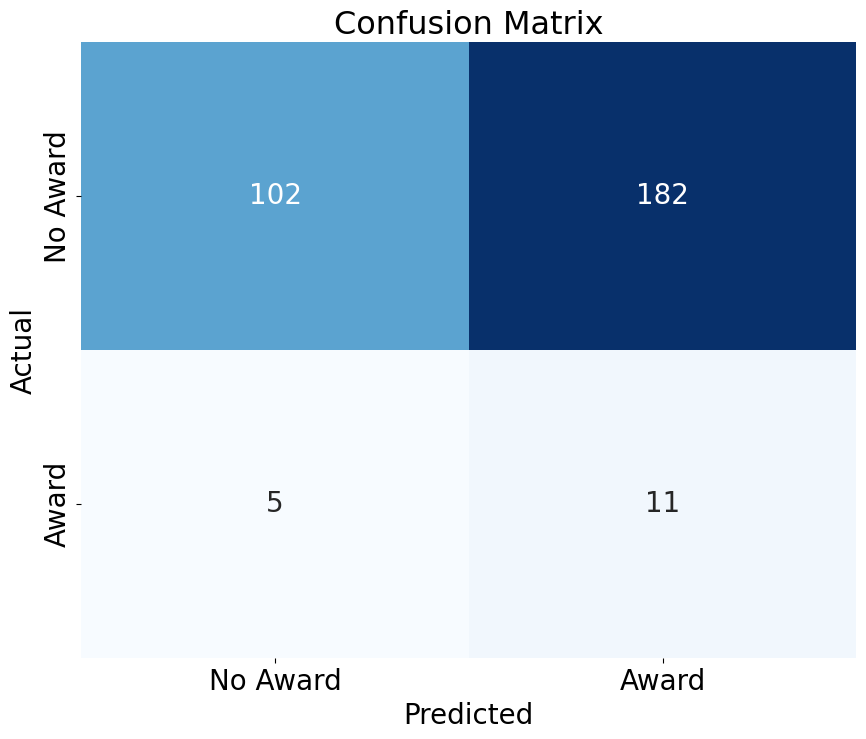

In [234]:
tokenizer = AutoTokenizer.from_pretrained('google/electra-small-discriminator')
test_dataloader = create_dataloader(df, tokenizer, 200, 16)

y_text, y_pred, y_pred_probs, y_test = get_predictions(model,test_dataloader)

# print f1 score
print('F1 score: ', f1_score(y_test, y_pred, average='macro'))

plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', cbar=False, annot_kws={"size": 20})
plt.xticks([0.5,1.5], ['No Award', 'Award'], fontsize=20)
plt.yticks([0.5,1.5], ['No Award', 'Award'],fontsize=20)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=23)
plt.show()

In [236]:
# Classification report
print(classification_report(y_test, y_pred, target_names=['No Award', 'Award']))

              precision    recall  f1-score   support

    No Award       0.95      0.36      0.52       284
       Award       0.06      0.69      0.11        16

    accuracy                           0.38       300
   macro avg       0.51      0.52      0.31       300
weighted avg       0.91      0.38      0.50       300

